In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

import os
import numpy as np
import matplotlib.pyplot as plt

# Global Variables
IMG_SIZE = 224
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

EPOCHS = 20

In [2]:
def load_images_from_folder(pair_folder):
    image1_path = os.path.join(pair_folder, 'image1.png')
    image2_path = os.path.join(pair_folder, 'image2.png')

    img1 = image.load_img(image1_path, target_size=(IMG_SIZE, IMG_SIZE))
    img2 = image.load_img(image2_path, target_size=(IMG_SIZE, IMG_SIZE))

    img1_array = image.img_to_array(img1)  # Rescale images to [0, 1]
    img2_array = image.img_to_array(img2)

    return img1_array, img2_array

def load_label(label_path):
    label = np.loadtxt(label_path, delimiter=',')
    return label

In [5]:
data_folder = r"../Training Data/UE5 Data"

images_folder = os.path.join(data_folder, "Images")
labels_folder = os.path.join(data_folder, "Labels")

images = []
labels = []

pair_num = 0

for pair_name in os.listdir(images_folder):
    try:
        pair_folder_path = os.path.join(images_folder, pair_name)
        image1, image2 = load_images_from_folder(pair_folder_path)

        label_path = os.path.join(labels_folder, pair_name + ".txt")
        label = load_label(label_path)
        
        images.append((image1, image2))
        labels.append(label)
        pair_num = pair_num + 1

        if pair_num % 100 == 0:
            print("Processed pair", pair_num)
    except FileNotFoundError as e:
        print("Error!", e)
        continue


Processed pair 100
Error! [Errno 2] No such file or directory: '../Training Data/UE5 Data/Images/pair_00480/image2.png'
Processed pair 200
Error! [Errno 2] No such file or directory: '../Training Data/UE5 Data/Images/pair_00592/image2.png'
Processed pair 300
Processed pair 400
Error! [Errno 2] No such file or directory: '../Training Data/UE5 Data/Images/pair_00469/image1.png'
Error! [Errno 2] No such file or directory: '../Training Data/UE5 Data/Images/pair_00527/image2.png'
Processed pair 500
Error! [Errno 2] No such file or directory: '../Training Data/UE5 Data/Images/pair_00667/image2.png'
Error! [Errno 2] No such file or directory: '../Training Data/UE5 Data/Images/pair_00668/image2.png'
Processed pair 600


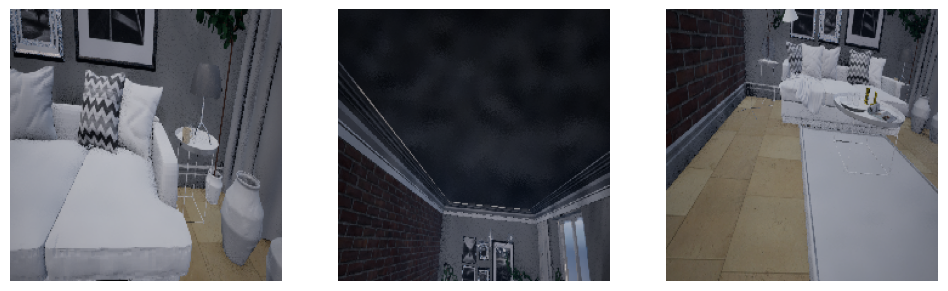

In [6]:
plt.figure(figsize=(12, 12))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    image1 = images[i][0]
    image1 = np.clip(image1, 0, 255).astype(np.uint8)
    
    plt.imshow(image1)
    plt.axis("off")
    
plt.show()

In [7]:
train_images = images[:int(len(images)//1.25)]
train_labels = labels[:int(len(labels)//1.25)]

test_images = images[int(len(images)//1.25):]
test_labels = labels[int(len(labels)//1.25):]

In [9]:
def unpack_tuple(images, label):
    return (images[0], images[1]), label

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.map(unpack_tuple).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.map(unpack_tuple).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [22]:
input_image1 = layers.Input(shape=IMG_SHAPE)
input_image2 = layers.Input(shape=IMG_SHAPE)

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

base_model.trainable = False

x1 = base_model(input_image1)
x2 = base_model(input_image2)

x1 = layers.GlobalAveragePooling2D()(x1)
x2 = layers.GlobalAveragePooling2D()(x2)

concatenated = layers.concatenate([x1, x2], axis=-1)

x = layers.Dense(512, activation='relu')(concatenated)
x = layers.Dense(256, activation='relu')(x)

output = layers.Dense(6)(x)

model = models.Model(inputs=[input_image1, input_image2], outputs=output)

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'accuracy'])

In [25]:
history = model.fit(
  train_dataset,
  epochs=EPOCHS)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9023 - loss: 2.0613 - mae: 0.9091
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9350 - loss: 1.5607 - mae: 0.7987
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9543 - loss: 1.2989 - mae: 0.7145
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9257 - loss: 1.4421 - mae: 0.7632
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9264 - loss: 1.2361 - mae: 0.6930
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9360 - loss: 1.1607 - mae: 0.6855
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9504 - loss: 0.7930 - mae: 0.5652
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9493 - loss: 0.5887 - mae: 0.5001
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9546 - loss: 0.4555 - mae: 0.4521
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9503 - loss: 0.4440 - mae: 0.4439
Epoch 11/

5/5 - 0s - 50ms/step - accuracy: 0.7879 - loss: 12.9279 - mae: 2.1302
Accuracy: 78.78788113594055%


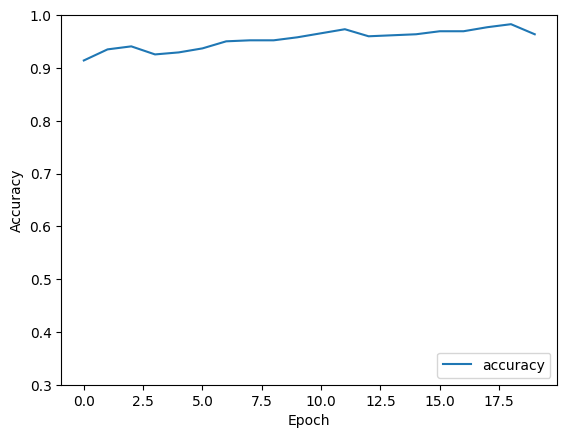

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

test_loss, mae, test_acc = model.evaluate(test_dataset, verbose=2)
print("Accuracy:", str(test_acc * 100) + "%")